In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2






In [2]:
# Data path
test_data_path = '../data/archive/test'
train_data_path = '../data/archive/train'

# each forlder has 7 subfolders representing 7 classes of emotions: anger, disgust, fear, happy, neutral, sad, surprise

#write folder structure
# archive (test, train) -> (anger, disgust, fear, happy, neutral, sad, surprise) -> (images)

<AxesSubplot:xlabel='emotion'>

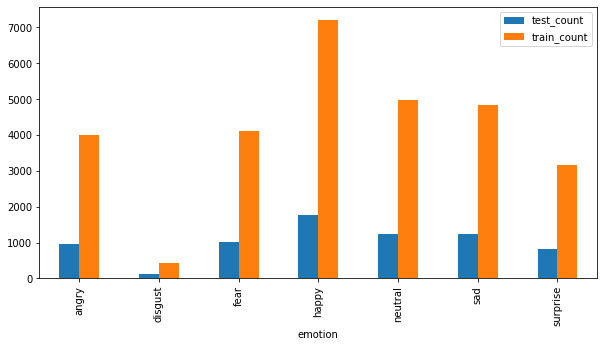

In [3]:
# Count number of images in each folder
# Test data
test_data = {}
for folder in os.listdir(test_data_path):
    test_data[folder] = len(os.listdir(os.path.join(test_data_path, folder)))
    
# Train data
train_data = {}
for folder in os.listdir(train_data_path):
    train_data[folder] = len(os.listdir(os.path.join(train_data_path, folder)))

# create  one dataframe for 7 emotion and number of images in each folder for test and train data
df = pd.DataFrame(test_data.items(), columns=['emotion', 'test_count'])
df['train_count'] = train_data.values()

df.plot(x='emotion', y=['test_count', 'train_count'], kind='bar', figsize=(10, 5))


In [4]:
# total number of images in test and train data, and total in whole dataset

test_total = df['test_count'].sum()
train_total = df['train_count'].sum()
total = test_total + train_total
print('Total number of images in test data: ', test_total)
print('Total number of images in train data: ', train_total)
print('Total number of images in whole dataset: ', total)

Total number of images in test data:  7178
Total number of images in train data:  28709
Total number of images in whole dataset:  35887


In [5]:
random_image = cv2.imread(os.path.join(test_data_path, folder, os.listdir(os.path.join(test_data_path, folder))[0]), cv2.IMREAD_GRAYSCALE)

In [6]:
random_image.shape

(48, 48)

# Data Preparation

In [7]:


import torch
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
# import nn


In [8]:
# check if cuda is available
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print('CUDA is available! Training on GPU...')
else:
    print('CUDA is not available. Training on CPU...')

CUDA is available! Training on GPU...


In [9]:
transform = transforms.Compose([
    transforms.Resize(32),
    # to-tensor
    transforms.ToTensor(),
    # normalize
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [10]:
train_data = datasets.ImageFolder(root='../data/archive/train', transform=transforms.ToTensor())
# train_data = datasets.ImageFolder(root='../data/archive/test', transform=transforms.ToTensor())
test_data = datasets.ImageFolder(root='../data/archive/test', transform=transforms.ToTensor())

    

In [11]:
# Load data on GPU if available
if train_on_gpu:
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
    
else:
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

# check if data is loaded correctly
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break




torch.Size([64, 3, 48, 48])
torch.Size([64])


# Model

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:

resnet = models.resnet18(weights= models.ResNet18_Weights.IMAGENET1K_V1)
resnet = resnet.to(device)
resnet.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
from tqdm import tqdm

In [17]:
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=5):
    
    for epoch in range(num_epochs):
 
            # print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            # train phase
            model.train()
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in tqdm(train_loader):
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                # backward pass
                loss.backward()
                optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(train_loader.dataset)
            # print('Training loss: {:.4f}'.format(epoch_loss))
            epoch_acc = running_corrects.double() / len(train_loader.dataset)
            # print('Training accuracy: {:.4f}'.format(epoch_acc))
            
            
            # validation phase
            model.eval()
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in test_loader:
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                
                
                
            epoch_loss = running_loss / len(test_loader.dataset)
            # print('Validation loss: {:.4f}'.format(epoch_loss))
            
            
            print(f'Epoch {epoch}/{num_epochs - 1} -- Training loss: {epoch_loss:.4f}    Training accuracy: {epoch_acc:.4f}   Validation loss: {epoch_loss:.4f}')

    return model


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model
model = train_model(resnet, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=5)





Epoch 0/4
----------


100%|██████████| 449/449 [00:07<00:00, 57.05it/s]


Epoch 0/4 -- Training loss: 1.2302    Training accuracy: 0.7876   Validation loss: 1.2302
Epoch 1/4
----------


100%|██████████| 449/449 [00:07<00:00, 58.80it/s]


Epoch 1/4 -- Training loss: 1.3402    Training accuracy: 0.8227   Validation loss: 1.3402
Epoch 2/4
----------


100%|██████████| 449/449 [00:07<00:00, 61.21it/s]


Epoch 2/4 -- Training loss: 1.4188    Training accuracy: 0.8748   Validation loss: 1.4188
Epoch 3/4
----------


100%|██████████| 449/449 [00:07<00:00, 60.54it/s]


Epoch 3/4 -- Training loss: 1.3924    Training accuracy: 0.8863   Validation loss: 1.3924
Epoch 4/4
----------


100%|██████████| 449/449 [00:07<00:00, 61.24it/s]


Epoch 4/4 -- Training loss: 1.5557    Training accuracy: 0.8685   Validation loss: 1.5557
